# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [60]:
import matplotlib.pyplot as plt
import numpy as np

class Capabilities:
    def __init__(self, material, gauge):
        self.material = material
        self.gauge = gauge
        self._extract_data()

    def _extract_data(self):
        self.gauge_material = f"{self.gauge}_{self.material}"

        self.thickness = {
            '16_glv': 0.0635,
            '14_glv': 0.0785,
            '12_glv': 0.1084,
            '10_glv': 0.1382,
            '16_sst': 0.0625,
            '14_sst': 0.0781,
            '12_sst': 0.1094,
            '10_sst': 0.1406,
        }

        self.max_flange_width = {
            '16_glv': 149.6,
            '14_glv': 149.6,
            '12_glv': 149.6,
            '10_glv': 118.11,
            '16_sst': 149.6,
            '14_sst': 118.11,
            '12_sst': 108.26,
            '10_sst': 82.67,
        }

        self.density = {
            '16_glv': 0.018444444444444444,
            '14_glv': 0.022784722222222224,
            '12_glv': 0.03146527777777777,
            '10_glv': 0.04014583333333333,
            '16_sst': 0.0175,
            '14_sst': 0.021875,
            '12_sst': 0.030625,
            '10_sst': 0.039375,
        }

        self.max_flange_length = 8
        self.min_flange_length = self.thickness[self.gauge_material] * 5
        self.min_throat_length = 15.75
        self.max_flat_diagonal = 157.48
        self.max_mass = 286.6

        self.MPB_max_dim = 168

        self.TB_max_length = 334.65
        self.TB_max_diagonal_width = 7.87
        self.TB_max_mass_per_length = 7.348

    def APB_MPB_TB_plot(self):
        # APB derived limits
        min_x = min_y = self.min_throat_length + 2 * self.max_flange_length
        max_x = max_y = self.max_flange_width[self.gauge_material]

        # Create grid for all
        x = np.linspace(1e-3, 340, 400)
        y = np.linspace(1e-3, 340, 400)
        X, Y = np.meshgrid(x, y)

        # APB Constraints
        circle_constraint = (X**2 + Y**2) <= self.max_flat_diagonal**2
        mass_constraint = (X * Y * self.density[self.gauge_material]) <= self.max_mass
        apb_feasible = (
            (X >= min_x) & (X <= max_x) &
            (Y >= min_y) & (Y <= max_y) &
            circle_constraint & mass_constraint
        )

        # MPB Constraints: x < 168, y < 168
        mpb_feasible = (X < self.MPB_max_dim) & (Y < self.MPB_max_dim)

        # TB (Tube Laser) Constraints
        TB_max_width = round(3*((self.TB_max_diagonal_width**2 / 2) ** 0.5), 2)
        tb_feasible = (Y < self.TB_max_length) & (X < TB_max_width) & ((X * (self.density[self.gauge_material])) <= self.TB_max_mass_per_length)

        plt.figure(figsize=(10, 10))
        # Plot TB region in red
        plt.contourf(X, Y, tb_feasible, levels=[0.5, 1], colors=['#e74c3c'], alpha=0.5)
        # Plot MPB region in blue
        plt.contourf(X, Y, mpb_feasible, levels=[0.5, 1], colors=['#4f8cd6'], alpha=0.3)
        # Plot APB region in green
        plt.contourf(X, Y, apb_feasible, levels=[0.5, 1], colors=['#66c2a5'], alpha=0.7)

        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')

        
        # Option 2: Create multi-colored title using text objects (uncomment to use this instead)
        ax = plt.gca()
        title_y = 1.02
        title_x = 0.1
        ax.text(0.5 - title_x, title_y, f'Manufacturing regions for {self.gauge_material}: ', transform=ax.transAxes, 
                fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.76 - title_x, title_y, 'TL', transform=ax.transAxes, 
                color='#e74c3c', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.79 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.83 - title_x, title_y, 'MPB', transform=ax.transAxes, 
                color='#4f8cd6', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.87 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.91 - title_x, title_y, 'APB', transform=ax.transAxes, 
                color='#66c2a5', fontsize=14, ha='center', va='bottom', fontweight='bold')

        # APB boundaries for reference
        theta = np.linspace(0, np.pi/2, 200)
        circle_x = self.max_flat_diagonal * np.cos(theta)
        circle_y = self.max_flat_diagonal * np.sin(theta)
        plt.plot(circle_x, circle_y, 'g:', label=f'APB: x² + y² = {self.max_flat_diagonal}²')
        x_mass = np.linspace(1e-3, max_x*10, 400)
        y_mass = self.max_mass / (self.density[self.gauge_material] * x_mass)
        density_rounded = round(self.density[self.gauge_material], 3)
        plt.plot(x_mass, y_mass, 'g--', label=f'APB: x·y·{density_rounded} = {self.max_mass}') 
        plt.axvline(min_x, color='g', linestyle=':', label=f'APB: min x,y = {min_x}')
        plt.axvline(max_x, color='g', linestyle=':', label=f'APB: max x,y = {max_x}')
        plt.axhline(min_y, color='g', linestyle=':')
        plt.axhline(max_y, color='g', linestyle=':')
        plt.axvline(self.MPB_max_dim, color='#4f8cd6', linestyle=':', label=f'MPB: max x,y = {self.MPB_max_dim}')
        plt.axhline(self.MPB_max_dim, color='#4f8cd6', linestyle=':')
        plt.axvline(TB_max_width, color='#e74c3c', linestyle=':', label=f'TL: max x = {TB_max_width}')
        plt.axhline(self.TB_max_length, color='#e74c3c', linestyle=':', label=f'TL: max y = {self.TB_max_length}')
        plt.axvline(self.TB_max_mass_per_length/self.density[self.gauge_material], color='#e74c3c', linestyle='--', label=f'TB: x·{round(self.density[self.gauge_material], 3)} = {self.TB_max_mass_per_length}')

        plt.legend(loc='upper right')
        plt.xlim(0, 200)
        plt.ylim(0, 340)
        plt.grid(True)
        plt.show()


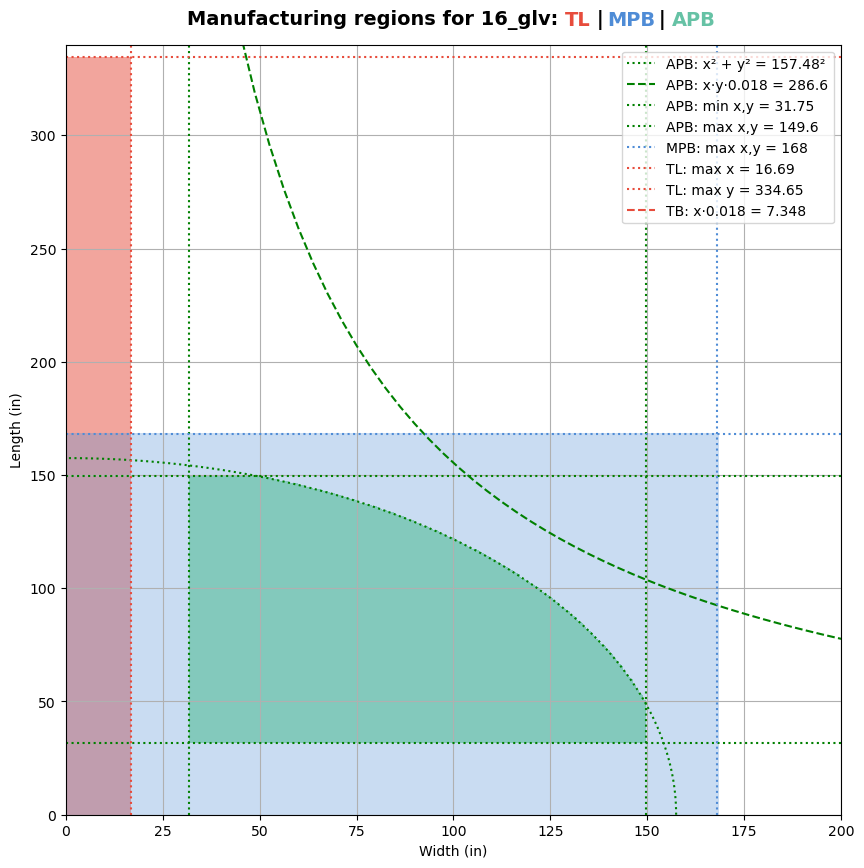

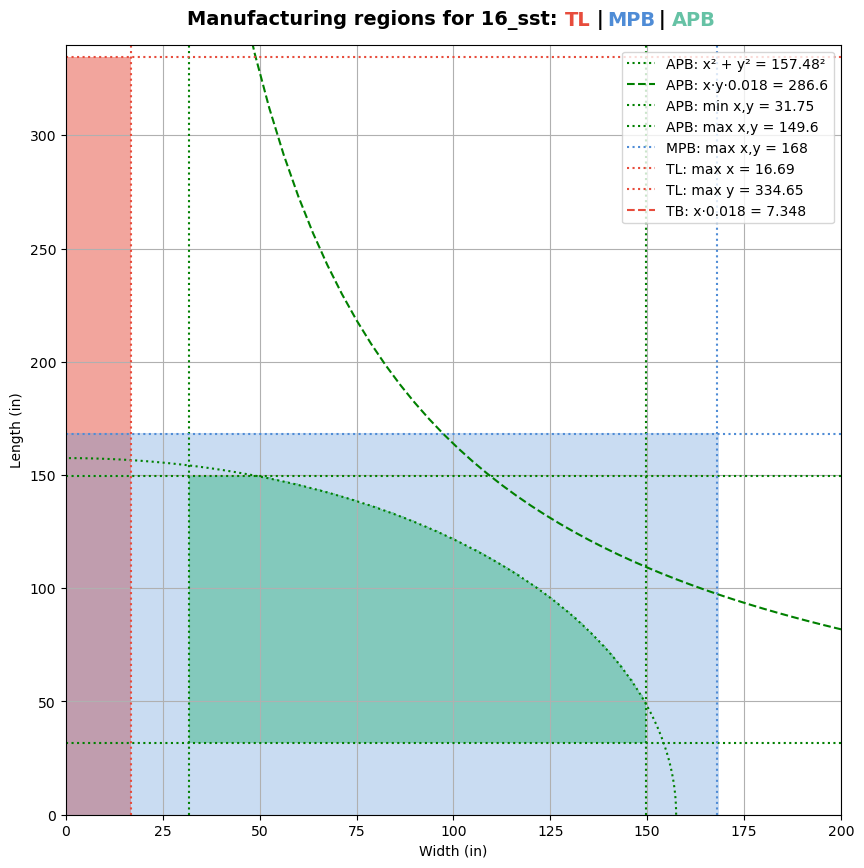

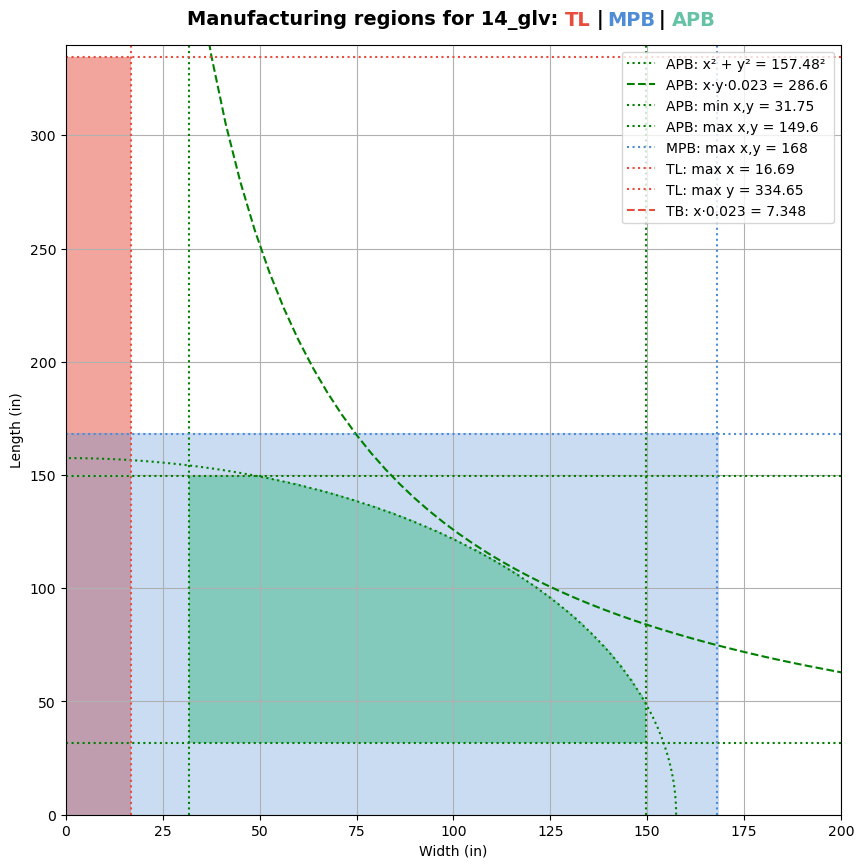

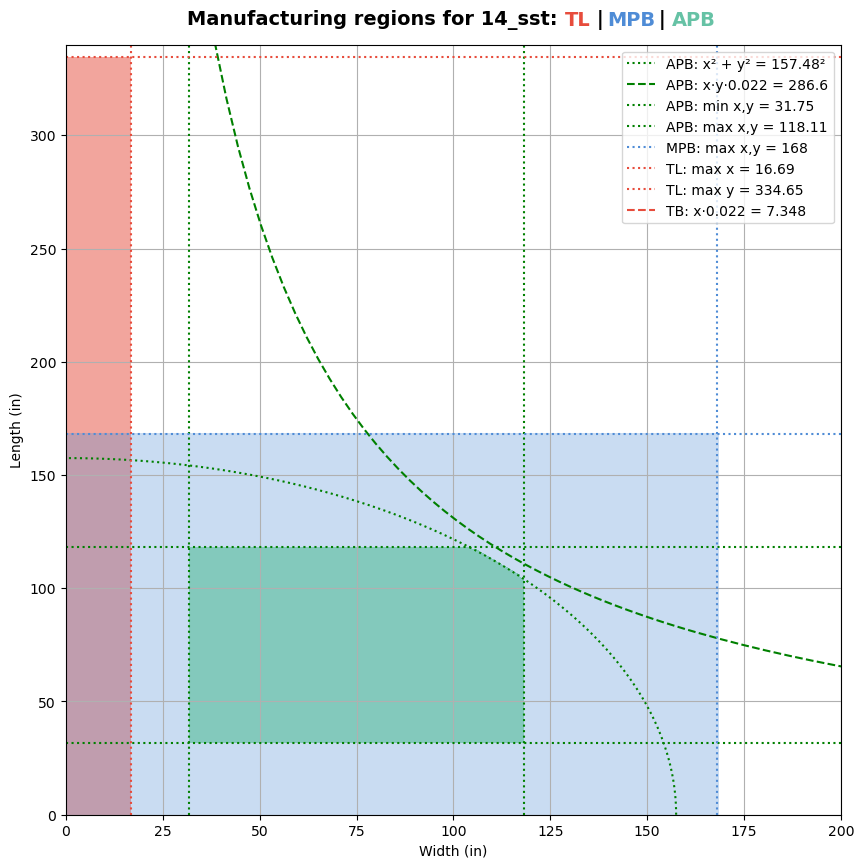

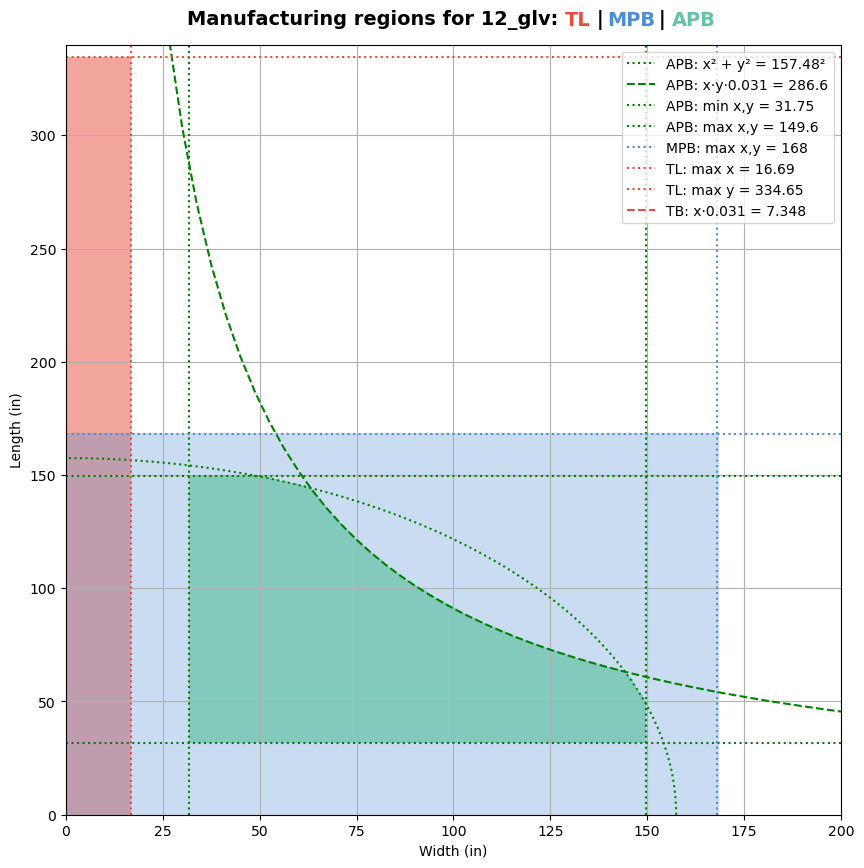

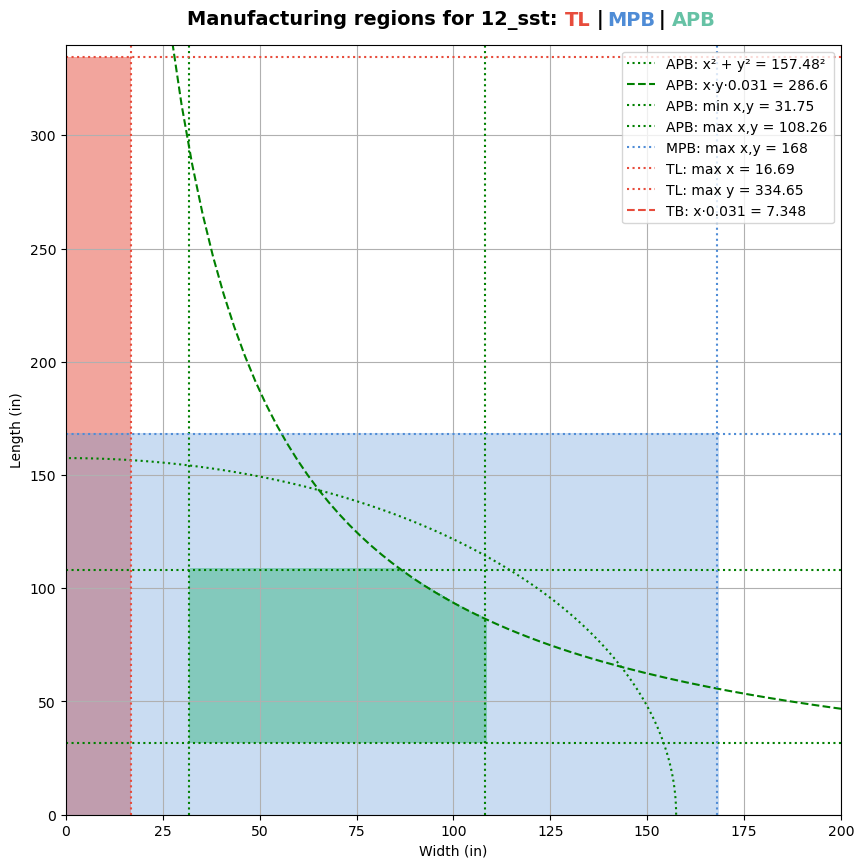

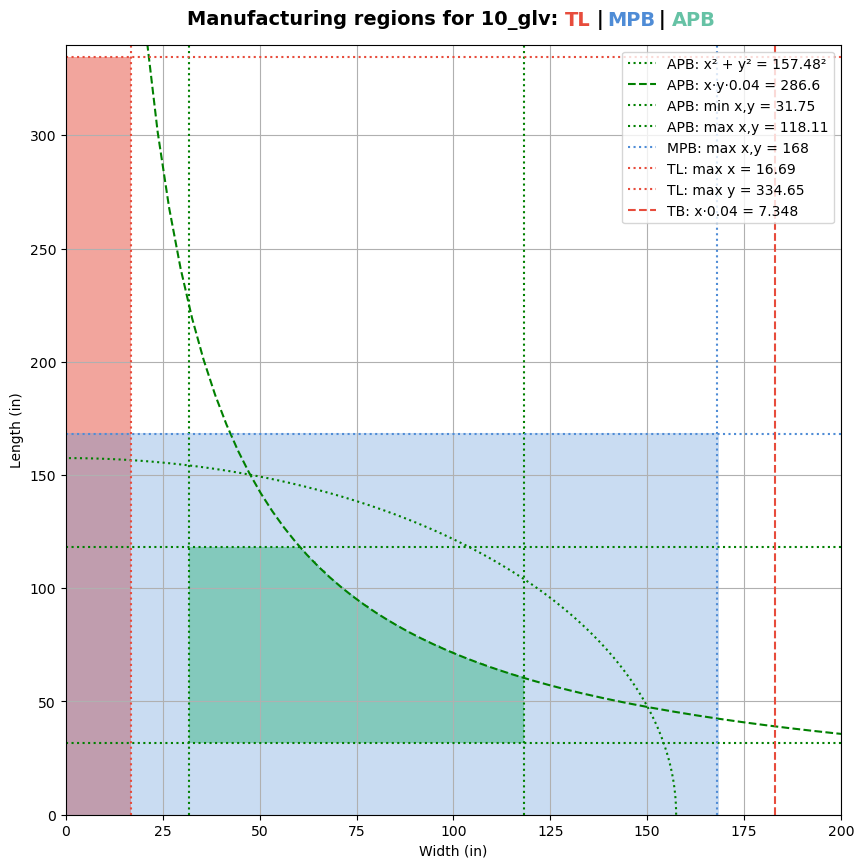

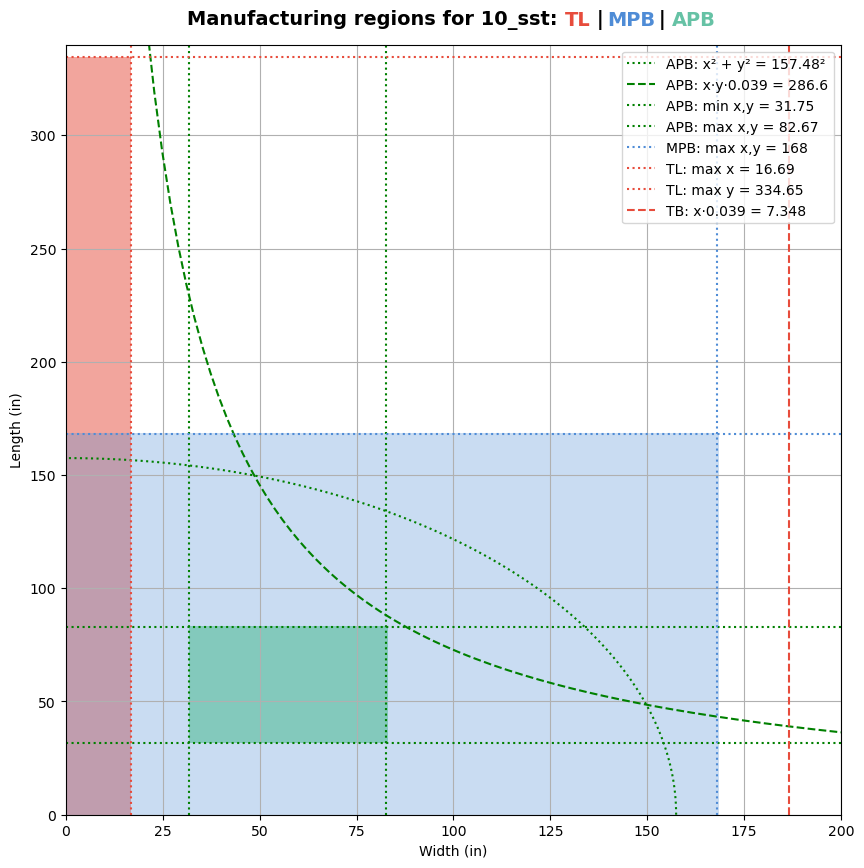

In [61]:
gauges = [16, 14, 12, 10]
materials = ['glv', 'sst']
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.APB_MPB_TB_plot()